In [3]:
using Sunny
using GLMakie
using LinearAlgebra
using Random

rng = MersenneTwister(111);

# Implementing and testing the model

We will begin by building the model and demonstrating that it produces the expected ground states.

## Model description

The Hamiltonian we will implement includes: nearest and next-nearest neighbor exchange interactions ($J$ and $J'$); a Kitaev-like term (K); and a quartic anisotropy term (D).  Formally, this can be written,

$H = J\sum_{\langle i, j \rangle} \mathbf{S}_i \cdot \mathbf{S}_j + J' \sum_{\langle\langle i, j \rangle\rangle} \mathbf{S}_i \cdot \mathbf{S}_j + K \sum_{\langle i, j \rangle_{\gamma}} S_i^{\gamma}S_j^{\gamma} + D \sum_i \left(S^x\right)^4 + \left(S^y\right)^4 + \left(S^z\right)^4$.

This Hamiltonian will be implemented on a face-centered cubic (FCC) latice.  

## Instantiating the model

To implement a model in Sunny, one first specifies a crystal structure and then assigns interactions to bonds (e.g. exchange) or sites (onsite anistropy). 


### FCC Crystal

Sunny has a built-in function for producing an FCC crystal, specifically: 

In [4]:
cryst = Sunny.fcc_crystal()

Crystal
HM symbol 'F m -3 m' (225)
Lattice params a=1, b=1, c=1, α=90°, β=90°, γ=90°
Volume 1
Class 1, Site sym 'm-3m', Wyckoff 4a:
   1. [0, 0, 0]
   2. [0.5, 0.5, 0]
   3. [0.5, 0, 0.5]
   4. [0, 0.5, 0.5]


Note that Sunny reports symmetry information about the crystal.  Sunny is here using a cubic unit cell with uniformly-sized lattice vectors (`a=b=c=1`) that are mutually orthogonal.  Further, Sunny reports a list of the locations of atoms within a unit cell, specified in terms of fractional coordinates.  Here we have atoms at the origin of the unit cell (1), and at the centers of the faces of the unit cell that meet at the origin (2-4).

### Assigning interactions to bonds

#### Exchange and Kitaev
Sunny automatically performs an analysis of symmetry equivalent bonds in the crystal. When an interaction is assigned to an individual bond in the crystal, Sunny will automatically propagate that interaction to all symmetry equivalent bonds, performing any necessary transformations.  It is therefore useful to obtain a list of symmetry _inequivalent_ bonds which can be used to specify unique interactions.  One way to do this is to use Sunny's `print_bond_table` function. This function takes two arguments.  The first is simply a crystal, and the second is the maximum distance to consider from the origin.  For example, to get a list of the bonds within the unit cell, one can simple type the following:

In [5]:
print_bond_table(cryst, 1.0)

Atom 1, position [0, 0, 0], multiplicity 4
Allowed single-ion anisotropy or g-tensor: | A  0  0 |
                                           | 0  A  0 |
                                           | 0  0  A |

Bond(1, 2, [0, 0, 0])
Distance 0.7071, coordination 12
Connects [0, 0, 0] to [0.5, 0.5, 0]
Allowed exchange matrix: | A  C  0 |
                         | C  A  0 |
                         | 0  0  B |

Bond(1, 1, [1, 0, 0])
Distance 1, coordination 6
Connects [0, 0, 0] to [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  0 |
                         | 0  0  B |



Ignoring for the moment the output corresponding to `Atom 1`, we note that we have found two symmetry-inequivalent bonds.  Sunny prints out the exact specification for each of these along with some additional information.

The first bond is labeled `Bond(1, 2, [0, 0, 0])`.  The first two numbers in this expression refer the ordered atoms inside each unit cell, where the ordering corresponds to the list produced when the crystal was first created (see above).  In this case, `1` refers to the atom at the origin of the unit cell, and `2` corresponds to the atom located at `[0.5, 0.5, 0]`. (This is also made clear on the line beginning with `Connects`.)  The list of numbers which follows, here `[0,0,0]`, refers to lattice offsets.  The two atoms are within the same unit cell, hence the zeros. The second bond connects the origins of two neighboring unit cells in the lattice. The distance between the atoms of each bond is also listed, making it clear the first bond is a nearest neighbor bond, and the second is a next-nearest neighbor.

For each bond Sunny provides an allowed "exchange matrix," which specifies the form that must be obeyed by a tensor specifying any bilinear interaction between the two atoms that define the bond.  Only exchange matrices that have such a form respect the symmetry of the crystal, and any exchange matrix which does not have this form cannot be propagated to other symmetry equivalent bonds.  Sunny will throw and error if you attempt to build a spin system with an invalid exchange matrix.

We now implement the two interactions necessary to capture the exchange and Kitaev terms of the Hamiltonian above.

In [6]:
J  = 1.0   # Anti-ferro nearest neighbor
J′ = -1.0  # Ferro next-nearest neighbor
K  = 1.0   # Scale of Kitaev term
Γ  = 0.0   # Off-diagonal exchange, not used

## Nearest neighbor interactions: Heisenberg and Kitaev

# Tensor for bilinear interactions between nearest neighbor sites,
# here combining Heisenberg exchange and the Kitaev term. Note that
# for the bond selected, Bond(1, 2, [0,0,0]), connecting [0,0,0]
# to [0.5,0.5,0], the coordinate selected for the Kitaev term is the
# third.
J_exch = [J     Γ   0.0;
          Γ     J   0.0;
          0.0  0.0  J+K]
interaction1 = exchange(J_exch, Bond(1, 2, [0,0,0]))


## Next-nearest neighbor interaction: Heisenberg only
interaction2 = heisenberg(J′, Bond(1, 1, [1,0,0]));

#### Onsite anisotropy

Recall that, when we printed out the bond table above, Sunny also printed out information about the form of a rank-2 tensor prescribing onsite anistropy, which in this case was a scalar multiple of the identity matrix. Thus any onsite anistropy term in this crystal must have the form $\left(S^x\right)^2 + \left(S^y\right)^2 + \left(S^z\right)^2$.

The current model does not call for any such term, but it does require a quartic onsite anistropy of the form $\left(S^x\right)^4 + \left(S^y\right)^4 + \left(S^z\right)^4$. We have implemented a procedure for modeling quartic anistropies of this form only.  (In the future, the full symmetry analysis capabilities of Sunny will be extended to such terms.)

In [7]:
D = 1.0 # Scale of onsite anistropy

interaction3 = onsite_quartic(D);

### Creating the model

We now have everything we need to build a spin system in Sunny. The dynamics of this spin system can now be simulated (or, alternatively, the spin system can be used for Monte Carlo simulations).

In [8]:
dims = (2,2,2)  # Dimensions of lattice (note that this is in unit cells, with each unit cell containing four atoms)
interactions_all = [interaction1, interaction2, interaction3]

sys = SpinSystem(cryst, interactions_all, dims)  # Instantiate the spin system


Spin System
Basis 4, Lattice dimensions (2, 2, 2)


## Ground states

We now wish to check that Sunny is capable of producing the expected ground states for this model, summarized for different parameter choices shown on the slide below (from slides of Paddison et al.)

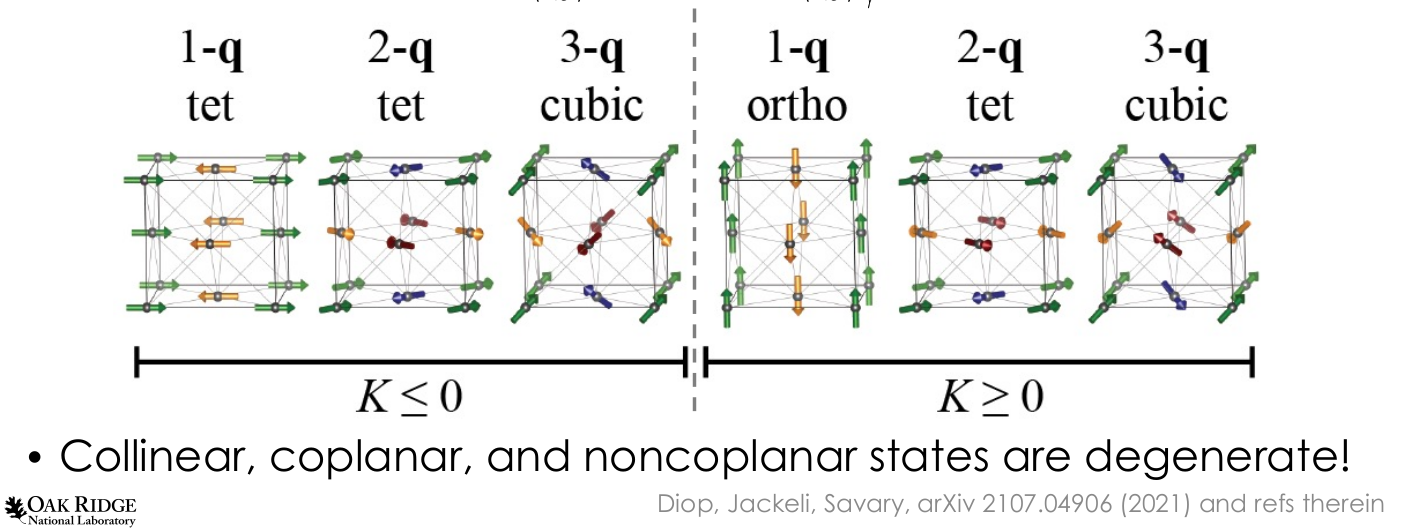



### K > 0.0, D > 0.0 (3-q cubic)
For the choice of parameters above (K > 0 and D > 0) we expect the 3-q cubic ordering shown on the far right of the slide.  We check this by simulating the evolution of the system from a random initial state using Landau-Lifshitz dynamics with damping.

In [9]:
Δt  = abs(0.02 / J)  # Safe choice for integration step size, where J is the largest coefficient in the Hamiltonian
dur = 40.0  # Duration of simulation
kT  = 0.0   # Zero temperature (meV)
α   = 0.1   # Damping coefficient
nsteps = round(Int, dur/Δt)

rand!(rng, sys)  # Initialize spin states to random positions
integrator = LangevinHeunP(sys, kT, α) # Use Langevin integrator to get damping, even though zero temperature
for _ ∈ 1:nsteps
    evolve!(integrator, Δt)
end

We now plot the results. (Note that the first plot may take a while to appear.)

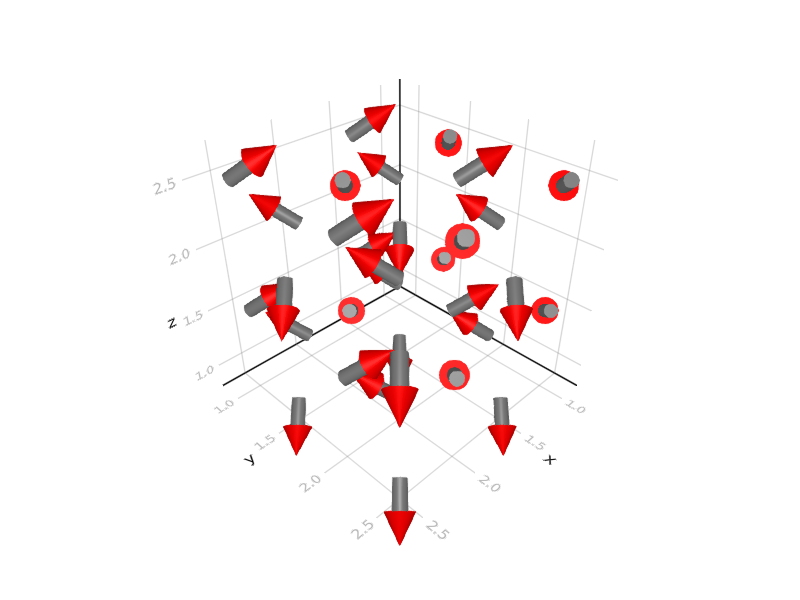

In [11]:
Sunny.plot_spins(sys)

Hopefully you see the 3-q cubic ordering!

We now perform the same test for other parameter choices: (1) K = 1.0, D = -1.0; (2) K = -1.0, D = 1.0; and (3) K = -1.0, D = -1.0. For these choices we expect 1-q ortho, 3-q cubic and 1-q tet, respectively.

When working through the following sections, you may want to execute each code block several times to make sure it produces the expected ordering consistently and does not get stuck in a local minimum.

### K > 0.0, D < 0.0 (1-q ortho)
We create a new spin system with these new parameters and follow the same procedure.

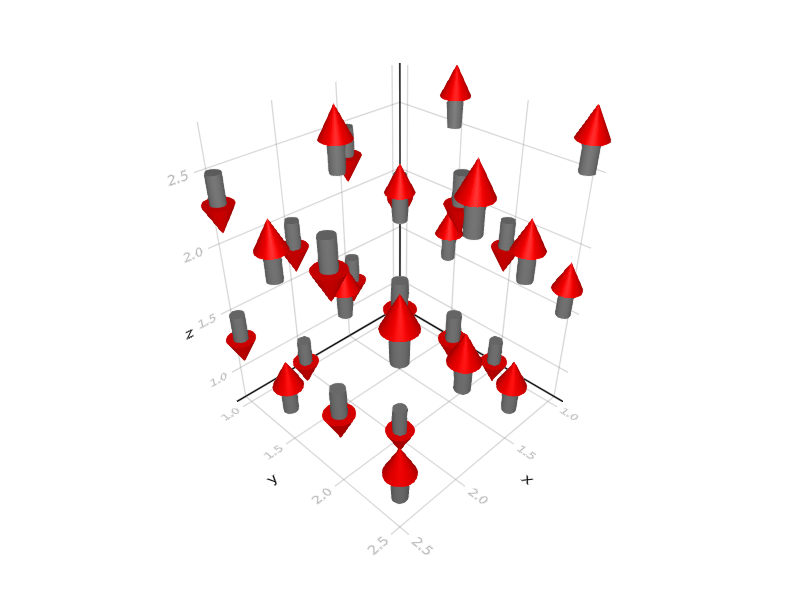

In [14]:
J    = 1.0   # Anti-ferro nearest neighbor
J′   = -1.0  # Ferro next-nearest neighbor
K    = 1.0   # Scale of Kitaev term
D    = -1.0 # Scale of onsite anistropy
Γ    = 0.0
dims = (2,2,2)

J_exch = [J     Γ   0.0;
          Γ     J   0.0;
          0.0  0.0  J+K]
interaction1 = exchange(J_exch, Bond(1, 2, [0,0,0]))
interaction2 = heisenberg(J′, Bond(1, 1, [1,0,0]))
interaction3 = onsite_quartic(D)
interactions_all = [interaction1, interaction2, interaction3]

sys = SpinSystem(cryst, interactions_all, dims)
rand!(rng, sys) 

integrator = LangevinHeunP(sys, kT, α) # Use Langevin integrator to get damping, even though zero temperature
for _ ∈ 1:round(Int, 100/Δt)
    evolve!(integrator, Δt)
end

Sunny.plot_spins(sys)

### K < 0.0, D > 0.0 (3-q cubic)

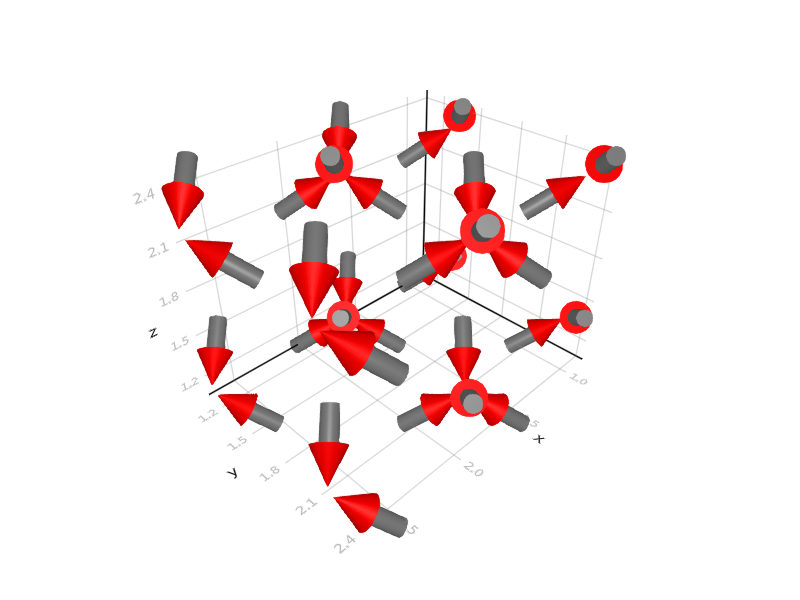

In [16]:
J    = 1.0   # Anti-ferro nearest neighbor
J′   = -1.0  # Ferro next-nearest neighbor
K    = -1.0   # Scale of Kitaev term
D    = 1.0 # Scale of onsite anistropy
Γ    = 0.0
dims = (2,2,2)

J_exch = [J     Γ   0.0;
          Γ     J   0.0;
          0.0  0.0  J+K]
interaction1 = exchange(J_exch, Bond(1, 2, [0,0,0]))
interaction2 = heisenberg(J′, Bond(1, 1, [1,0,0]))
interaction3 = onsite_quartic(D)
interactions_all = [interaction1, interaction2, interaction3]

sys = SpinSystem(cryst, interactions_all, dims)
rand!(rng, sys) 

integrator = LangevinHeunP(sys, kT, α) # Use Langevin integrator to get damping, even though zero temperature
for _ ∈ 1:round(Int, 100/Δt)
    evolve!(integrator, Δt)
end

Sunny.plot_spins(sys)

### K < 0.0, D < 0.0 (1-q tet)

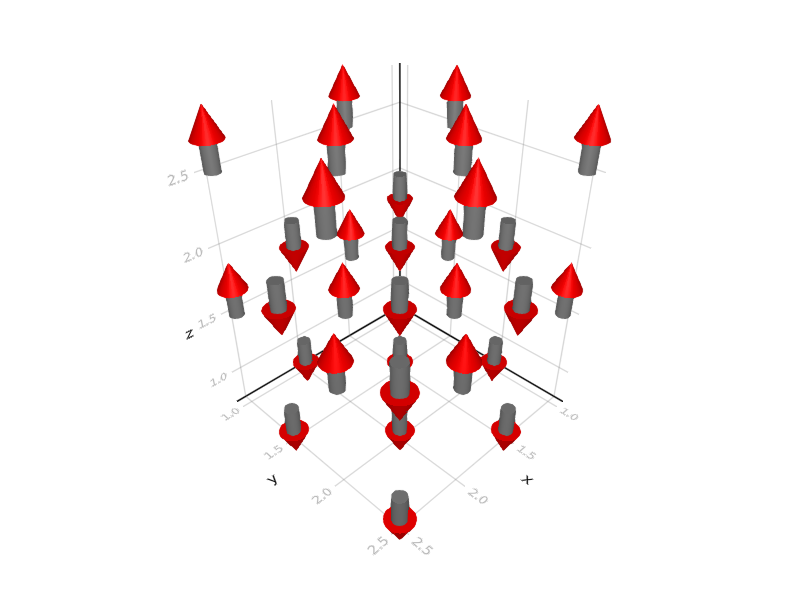

In [17]:
J    = 1.0   # Anti-ferro nearest neighbor
J′   = -1.0  # Ferro next-nearest neighbor
K    = -1.0   # Scale of Kitaev term
D    = -1.0 # Scale of onsite anistropy
Γ    = 0.0
dims = (2,2,2)

J_exch = [J     Γ   0.0;
          Γ     J   0.0;
          0.0  0.0  J+K]
interaction1 = exchange(J_exch, Bond(1, 2, [0,0,0]))
interaction2 = heisenberg(J′, Bond(1, 1, [1,0,0]))
interaction3 = onsite_quartic(D)
interactions_all = [interaction1, interaction2, interaction3]

sys = SpinSystem(cryst, interactions_all, dims)
rand!(rng, sys) 

integrator = LangevinHeunP(sys, kT, α) # Use Langevin integrator to get damping, even though zero temperature
for _ ∈ 1:round(Int, 100/Δt)
    evolve!(integrator, Δt)
end

Sunny.plot_spins(sys)

# Dynamical structure factor

A detailed tutorial on calculating dynamical structure factors in Sunny can be found [here](https://sunnysuite.github.io/Sunny.jl/dev/examples/), and more information on structure factors in general and the Sunny type for working with them can be found [here](https://sunnysuite.github.io/Sunny.jl/dev/structure-factor/). In this notebook we just indicate the general process for setting up the calculation and describe what the important parameters are.

The basic process consists of setting up a spin system, thermalizing it for an appropriate period of time, and then taking sample spin configurations. Full trajectories are then calculated for each of these initial conditions using energy-preserving Landau Lifshitz dynamics. The Fourier transforms of these trajectories are then calculated in the appropriate way and the results averaged, yeilding the function, $S^{\alpha, \beta}\left(\mathbf{q}, \omega\right)$, where $\alpha$ and $\beta$ index the components of the spin dipole (i.e. $x$, $y$ and $z$), $\mathbf{q}$ is a wave vector given in terms of the reciprocal lattice vectors, and $\omega$ is frequency (corresponding to the time dimension of the spin trajectories).

Sunny provides a built-in function to perform all these steps, returning an array corresponding to $S^{\alpha, \beta}\left(\mathbf{q}, \omega\right)$. Before calling this function, we must first set up a spins system, exactly as we did above.

In [274]:
J    = 1.0   # Anti-ferro nearest neighbor
J′   = -1.0  # Ferro next-nearest neighbor
K    = 1.0   # Scale of Kitaev term
D    = 1.0 # Scale of onsite anistropy
Γ    = 0.0
dims = (8,8,8)

J_exch = [J     Γ   0.0;
          Γ     J   0.0;
          0.0  0.0  J+K]
interaction1 = exchange(J_exch, Bond(1, 2, [0,0,0]))
interaction2 = heisenberg(J′, Bond(1, 1, [1,0,0]))
interaction3 = onsite_quartic(D)
interactions_all = [interaction1, interaction2, interaction3]

sys = SpinSystem(cryst, interactions_all, dims)
rand!(rng, sys);

The dynamical structure factor calculation requires a sampler to generate initial conditions, which are then used to integrate full trajectories.  Here we sample using Langevin dynamics. To create the Langevin sampler, it is necessary to specify temperature (`kT`), a damping coefficient (`α`, a value of 0.1 is generally sensible), and the number of steps to evolve the dynamics between taking samples (`nsteps`).

The `nsteps` parameter should be chosen such that successive samples are decorrelated. Too few steps will yield initial conditions that are not independent, and too many steps will naturally increase the duration of the calculation.  For important calculations, it is generally wise to analyze some trajectories produced by the Langevin dynamics to determine an appropriate decorrelation time. See the final section of the document for more details on determining this value.

In [275]:
kT = Sunny.meV_per_K * 0.01  # This is 0.1 Kelvin -- just showing for reference
α  = 0.1  # Damping coefficient
nsteps = 10_000  # Time steps between samples
sampler = LangevinSampler(sys, kT, α, Δt, nsteps);

We are now in a position to actually call the `dynamic_structure_factor` function. The function takes a spin system and a sampler. It can also be given a number of optional parameters, some of which are described below.

The number of thermodynamic samples (i.e. the number of random initial conditions and trajectories) is determined by `nsamp`.

The time resolution of the trajectory simulations is set by `dynΔt`, which in turn determines the maximum frequency captured by the discrete Fourier transform.  Specifically, the maximum frequency is given by `1/dynΔt`, assuming that every time step is used.  However, there is also the option to take only a subset of time steps, e.g. every 10.  This measurement frequency is set with `meas_rate`.  This reduces the maximum frequency of the calulcation as `ωmax = 2π / (dynΔt * meas_rate)`. 

`thermalize` determines the number of times to run the sampler before actually collecting samples.  Note that the `nsteps` above was determined in order to make sure consecutive samples are decorrelated, assuming that the system has already been thermalized.  If the system requires, say, 10 times this number of steps to thermalize from a random initial condition, one would set `thermalize` to 10.

`reduce_basis` is an option affecting the format of the structure factor returned by the function. By setting this to true, Sunny performs phase-weighted sums over sublattice indices, permitting the resulting data structure to be indexed directly in terms of $\mathbf{q}_i$.

The `dipole_factor` determines whether to apply the neutron dipole form factor to the results.

The code to perform the dynamic structure factor calculation follows.  Note that it may take some time to perform the calculation.

In [277]:
meas_rate = 40
dyn_meas  = 400

dynsf = dynamic_structure_factor(
    sys, sampler; nsamples=12, dynΔt=Δt, meas_rate, dyn_meas, thermalize=5, verbose=true,
    reduce_basis=true, dipole_factor=false
)

Sample: 100%|███████████████████████████████████████████| Time: 0:28:07


Beginning thermalization...
Done thermalizing. Beginning measurements...


3x3x8x8x8x400 StructureFactor

## Accessing the structure factor data

`dynsf` is a data structure containing the structure factor, which can be accessed directly via `dynsf.sfactor`.  `sfactor` itself is a `3x3x4x4x4x400` element array.  The first three indices range from `1` to `3`, corresponding to the `x`, `y`, and `z` components of the spin.  The following three indices have the same dimension as our lattice (`8x8x8`), and are given in terms of the reciprocal lattice vectors. The final index corresponds to $\omega$.

Note that `dynsf` uses a special indexing scheme. While the first two dimensions use indices ranging from `1` to `3`, as is standard in Julia, the remaining indices are handled differently.  If `Lx`, `Ly`, and `Lz` are the dimensions of our lattice, then the indices for the `x` index will range from `div(Lx-1, d)` to `div(Lx-1,2,RoundUp)` in integer steps, and similarly for `Ly` and `Lz`.  For the case of a `8x8x8` lattice, the indices will be taken from the set `[-3, -2, -1, 0, 1, 2, 3, 4]`, corresponding to values of `[-3pi/4, -pi/2, -pi/4, 0, pi/4, pi/2, 3pi/4, pi]`.  

Like the $\mathbf{q}$ vectors, the final dimension, corresponding to $\omega$, uses indexing beginning with `0`.

In this example, we will only consider only the symmetric structure factor by summing over diagonal elements, i.e. $\mathscr{S}^{xx} + \mathscr{S}^{yy} + \mathscr{S}^{zz}$. This can be calculated as follows.

In [278]:
sfactor = dynsf.sfactor  # Pull out structure factor data
avg_sfactor = zeros(Float64, axes(sfactor)[3:end])  # Preallocate data for symmetric structure factor
for i ∈ 1:3
    @. avg_sfactor += real(sfactor[i,i,:,:,:,:])  # Add each diagonal component of structure factor
end

## Plotting structure factor data

We are now in a position to plot extracts from the structure factor.  We just give one example of a cut, specifically one running from $\mathscr{S}(0,0,\pi)$ to $\mathscr{S}(\pi,0,\pi)$, and then from this same position, $\mathscr{S}(\pi,0,\pi)$, to $\mathscr{S}(\pi,\pi,\pi)$.

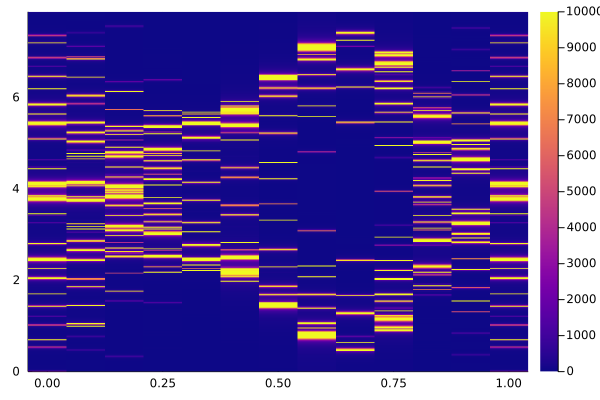

In [290]:
using Plots

S = avg_sfactor  # Give our symmetric structure factor a simpler name
Lx, Ly, Lz, T = size(S)   # Get dimensions of structure factor (linear dimensions of lattice followed by number of time steps)
ωmax = 2π/(dynsf.dynΔt*dynsf.meas_rate);  # Determine the highest frequency

πx, πy, πz = map(l->div(l, 2, RoundUp), (Lx, Ly, Lz))  # Determine the indices of the π points in each dimension
qz = πz   # Set qz index to the corresponding π-point
chopω = ωmax  # Set the upper limit on the frequency, here the maximum calculated

pathlen = πx+πy+min(πy, πx)+1  # Determine the number of indices in the cute
cuts = Array{Float64}(undef, pathlen, cutT)  # Preallocate memory for the cut
cuts[1:πx+1,       1:end]    .= S[0:πx, 0,    qz, 0:T-1]  # Populate pre-allocated memory with first leg of slice
cuts[πx+2:πx+πy+1, 1:end]    .= S[πx,   1:πy, qz, 0:T-1]  # Populate with second leg of slice
# Doesn't quite reach (0, 0, qz) for πx ≠ πy
for i in 1:min(πx,πy)
    cuts[πx+πy+1+i, 1:end]   .= S[πx-i, πx-i, qz, 0:T-1]
end

pathcoords = range(0., 1.; length=pathlen)  # Set up x-axis points
ωs = range(0., chopω, length=cutT)  # Set up y-axis points
Plots.heatmap(pathcoords, ωs, cuts'; color=:plasma, clim=(0.0, 10000))

**Note**: You may wish to adjust the upper bound of `clim=(0.0,10000)` to adjust the color scale of the plot

**Note further**: I believe the way this code was written, all discrete Fourier transform data are retained in the structure factor. Consequently, only the first half of the $\omega$ values contain unique information.  Given this, you may generally just wish to plot the first half of the $\omega$-axis.

(More precisely, the FFT returns positive frequencies in the first half of the array, and negative frequencies in the second half (starting with "most negative" and ascending from there).  Since we are Fourier transforming real numbers (spin positions), the values returned for negative frequencies will just be the complex conjugates of the corresponding positive frequency values. The intensities of the negative frequencies will thus be the same as the intensities of the corresponding positive frequencies.)

# Sampling initial conditions: burn-in and decorrelation time

There are two important considerations when generating initial conditions with a Langevin sampler.  If one starts from a random initial condition, it is necessary to make sure that the system has thermalized completely before taking samples. Further, one must make sure that a sufficient time has passed between successive samples so that the two samples are not correlated.

## Burning in

One can easily get a rough estimate of the thermalization time by examining the energy of a spin system over time starting from a random initial condition.  We give an example below using the same system.

In [266]:
## Make the spin system

J    = 1.0   # Anti-ferro nearest neighbor
J′   = -1.0  # Ferro next-nearest neighbor
K    = 1.0   # Scale of Kitaev term
D    = 1.0 # Scale of onsite anistropy
Γ    = 0.0
dims = (8,8,8)

J_exch = [J     Γ   0.0;
          Γ     J   0.0;
          0.0  0.0  J+K]
interaction1 = exchange(J_exch, Bond(1, 2, [0,0,0]))
interaction2 = heisenberg(J′, Bond(1, 1, [1,0,0]))
interaction3 = onsite_quartic(D)
interactions_all = [interaction1, interaction2, interaction3]

sys = SpinSystem(cryst, interactions_all, dims)
rand!(rng, sys);

## Set up an integrator and save a trajectory
kT = Sunny.meV_per_K * 10.0
α  = 0.1
int = LangevinHeunP(sys, kT, α)
Δt  = abs(0.02 / J)  # Safe choice for integration step size, where J is the largest coefficient in the Hamiltonian
dur = 100.0  # Duration of simulation
nsteps = round(Int, dur/Δt)


## Calculate the energy and plot
Es = zeros(nsteps)
for i in 1:nsteps
    evolve!(int, Δt)
    Es[i] = energy(sys)
end

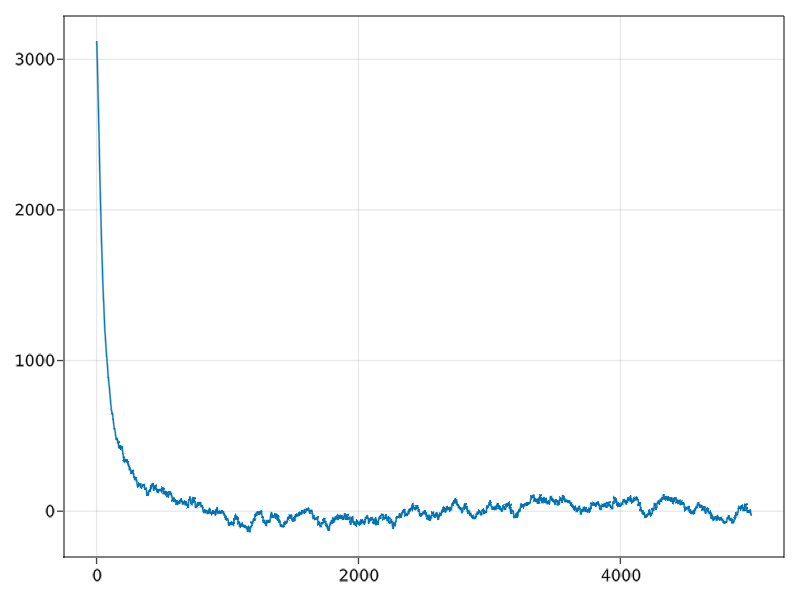

In [267]:
lines(Es)

We can see that this system appears to have thermalized after about 1500 steps.

## Decorrelation time

To determine the decorrelation time, it is generally best to work with whatever order parameter one is interested in studying.  A time series in terms of this order parameter should be calculate, just as we just did for energy.  To keep this example simple, we will just examine the decorrelation time for the energy itself.

This can be done relatively simply by studying the autocorrelation of a time series taken after the system has thermalized. Since we have already thermalized our system, we will simply continue integrating the trajectory we have started and record the energy for a longer duration.

In [271]:
dur = 1000.0  # Duration of simulation
nsteps = round(Int, dur/Δt)

Es = zeros(nsteps)
for i in 1:nsteps
    evolve!(int, Δt)
    Es[i] = energy(sys)
end

We will now examine the autocorrelation function, which we will calculate with the Fast Fourier Transform.

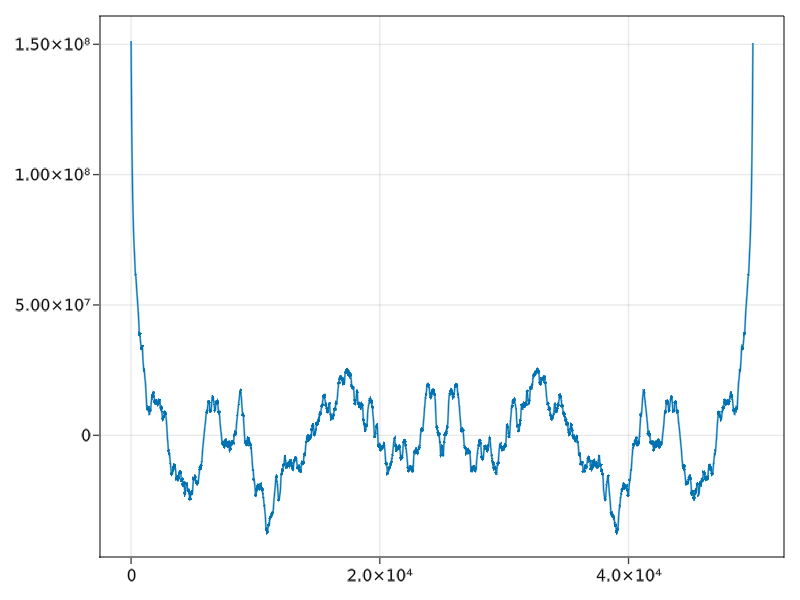

In [272]:
using FFTW

ωs = fft(Es)
spec = ωs .* conj(ωs)
ac = real.(ifft(spec))

lines(ac)

Note that again, due to the properties of the discrete Fourier transform, we are only interested in the first half of the result.  The decorrelation time can be estimated by considering the width of the initial peak.  It appears here that evidence of the peak disappears by around 5000 steps, which can be taken as a lower bound when selecting the `nsteps` parameter for the Langevin sampler.

Of course, to be more rigorous, one should examine many trajectories and study the specific effect each choice has on the results.  But this example gives a good idea of the general approach.